In [53]:
import numpy as np
from numpy import fft
import finite 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
   
    pcm = ax.pcolormesh(xm, ym, data)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()



N = 73
L = 1600E-9
a = 16E-9


grid_x = finite.UniformPeriodicGrid(N,L)
grid_y = finite.UniformPeriodicGrid(N,L)
domain = finite.Domain([grid_x, grid_y])
x, y = domain.values()
xm, ym  = np.meshgrid(x, y)

H = np.zeros((N,N))
RHO = np.zeros((N,N))

#Hinitial = 1/(2*np.pia***2)*np.exp(-((L/2-x)**2+(L/2-y)**2)/(2*a**2))
Hinitial = np.exp(-1E-2/a**2*(x-L/2)**2)*np.exp(-1E-2/a**2*(y-L/2)**2)
#Hinitial = np.zeros((N,N))
H = Hinitial
RHOinitial = np.zeros((N,N))
RHO = RHOinitial


Hcoff  = fft.fft2(H,norm='backward')
RHOcoff  = fft.fft2(RHO,norm='backward')



# q matrix
n= np.arange(-(N-1)/2,(N-1)/2+1)
m = np.arange(-(N-1)/2,(N-1)/2+1)
n = np.matrix(n)
m = np.matrix(m)
m = np.transpose(m)

q = np.square(n)+np.square(m)
q = np.array(q)
q = np.sqrt(q)
q.astype(complex)
q[int((N-1)/2),int((N-1)/2)]=0
qplot = q
q =q/L*2*np.pi



tot =10 #TRIALS FOR VARIANCE 
Hs = np.zeros([N,N,tot],dtype=np.complex128)


In [54]:
#set parameters 
dt = 3.2E-9
nu = 0.02
k=0.07
d=1E-9
mu=1E-8
b=1E7
Tem = 310
Kb= 1.38E-23
KbT = Kb*Tem
kapa = 20*KbT
kapaS = 2*d**2*k+20*KbT
gamma = 0

#for stochastic integration 

t=0

T = 1000*dt
cadence =1
n=0

for idx in np.arange(tot):
    t=0
    Hcoff  = fft.fft2(Hinitial,norm='backward')
    RHOcoff  = fft.fft2(RHOinitial,norm='backward')



    
    while t<T:
        #deterministic term 
        Hcoffnew = Hcoff + dt*(-kapaS*Hcoff*(q**4)-gamma+2*k*d*(q**2)*RHOcoff)/(4*nu*q)
        RHOcoffnew = RHOcoff + (dt*q**2)*(2*k*d*(q**2)*Hcoff-2*k*RHOcoff)/(4*b+4*nu*q+2*mu*q**2)
    

        #add stochastics term
        for i in range(N):
            for j in range(N):
                Hcoffnew[i,j] = Hcoffnew[i,j]+np.random.normal(0,float(((L**2)*(KbT)*dt/(4*nu*q[i,j]))**2),1)
                RHOcoffnew[i,j] = RHOcoffnew[i,j]+np.random.normal(0,float(((L**2)*(KbT)*dt*q[i,j]**2/(4*b+4*nu*q[i,j]+2*mu*q[i,j]**2))),1)

        Hcoff = np.copy(Hcoffnew)
        Hcoff[int((N-1)/2),int((N-1)/2)]=1E-16
        RHOcoff = np.copy(RHOcoffnew)
      
        
        

        t += dt
    Hs[:,:,idx] = Hcoff
   
       

  

    
  
    



C:\Users\gonza\AppData\Local\Temp\ipykernel_26348\3994013574.py:33: RuntimeWarning: invalid value encountered in divide
  Hcoffnew = Hcoff + dt*(-kapaS*Hcoff*(q**4)-gamma+2*k*d*(q**2)*RHOcoff)/(4*nu*q)
C:\Users\gonza\AppData\Local\Temp\ipykernel_26348\3994013574.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  Hcoffnew[i,j] = Hcoffnew[i,j]+np.random.normal(0,float(((L**2)*(KbT)*dt/(4*nu*q[i,j]))**2),1)


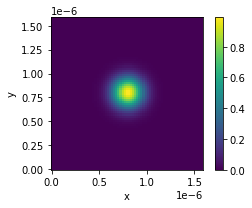

In [55]:
#convert to position space 
Hr = fft.ifft2((Hcoff),norm='backward')
Hr = np.real(Hr)
RHOr = fft.ifft2((RHOcoff),norm='backward')
RHOr = np.real(RHOr)

plot_2D_field(xm,ym,Hinitial)

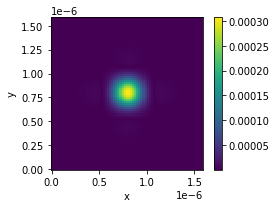

In [56]:
#coefficients plot 
plot_2D_field(xm,ym,np.abs(Hr))

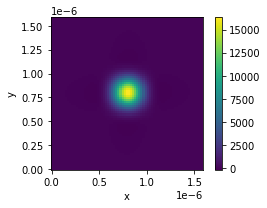

In [57]:
#density PLOT 
plot_2D_field(xm,ym,np.transpose(RHOr))


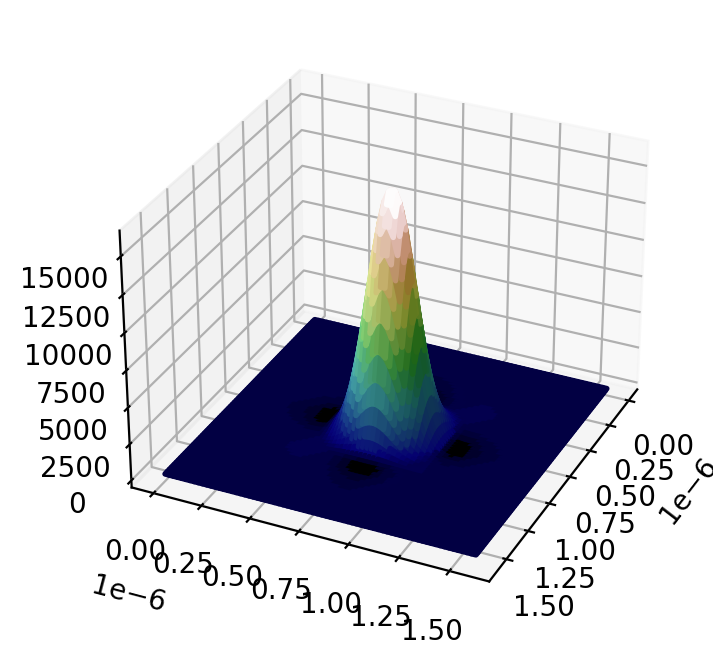

In [58]:
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))


ls = LightSource(0, 45)
rgb = ls.shade(Hr, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(xm, ym, RHOr, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=2, antialiased=True, shade=False)
ax.view_init(30, 25)
fig.set_dpi(200)
plt.show()
#membrane plot                     

C:\Users\gonza\AppData\Local\Temp\ipykernel_26348\2149777231.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(qplot.ravel(),np.log(variance.ravel()),'*')


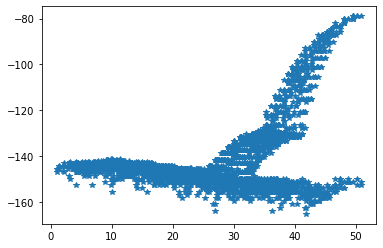

In [59]:
#spectrum, calculating variance over 10 trials
variance= np.abs(np.var(Hs,2))
variance[int((N-1)/2),int((N-1)/2)]=None
plt.plot(qplot.ravel(),np.log(variance.ravel()),'*')
